# Matrix Spectral Factorization
Here we employ the Chandrasekhar-Kailath-Morf-Sidhu (CKMS) Filter. This process requires the specral density to be in the form of a Laurent polynomial (or the ratio of Laurent polynomials). So, the first thing to do will be to fit a Laurent polynomial to the function.

In [22]:
using LinearAlgebra
using FFTW
using StatsBase

using Plots
pyplot()

include("SFbyCKMS_Matrix.jl")

Matrix_CKMS_c (generic function with 1 method)

In [23]:
# Graph stuff
Nex = 1000;
Theta = 2pi*(0:Nex)/Nex;
Z = map(th -> exp(im*th),Theta);

Here is the model:
$$X_t = \Phi_1X_{t-1} + A_t$$
where
$$\Phi_1 = \begin{pmatrix} r_1 + \gamma & \gamma\\
r_1 + \gamma - r_2 & r_2 - \gamma \end{pmatrix} \qquad \text{and}\qquad A_t \sim N(0,R)$$
Here we choose $r_1 = -0.8$, $r_2 = 0.6$, and $\gamma = 0.4$. and $R = I$. 

The $z$-spectrum of this is 
$$S_X(z) = \frac{25z}{(3z - 5)(4z + 5)(5z - 3)(5z + 4)}
\begin{pmatrix} 
5(z^2 - 6z + 1) & 25z^2 - z + 10 \\
10z^2 - z + 25  & 2(5z^2 + 27z + 5) \\
\end{pmatrix}$$

This has known factorization of 
$$L(z) = \begin{pmatrix}1 - 0.4z^{-1} & 0.4z^{-1}\\
z^{-1} & 1-0.2z^{-1}\end{pmatrix}$$

In [24]:
# Model stuff
steps = 10^6
discard = 10^4

10000

In [25]:
# # VAR(1) Process
# Phi1 = [-0.4 0.4; -1 0.2]

# S_X_minus_ana(z) = inv(I - Phi1.*z^(-1))

# S_X_ana(z) = S_X_minus_ana(z)*S_X_minus_ana(z)'

# X = zeros(2, steps + discard)
# A = randn(2, steps + discard)

# for i = 2 : steps + discard
#     X[:,i] = Phi1*X[:,i-1] + A[:,i]
# end
# X = X[:,discard + 1: steps + discard]

# plot(X[:,100:200]')

## MA(1) Diagonal

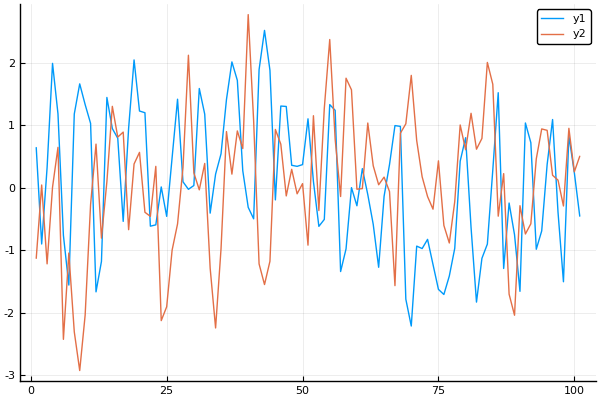

In [26]:
# MA(1) Diagonal process
r1, r2 = 1 .- 2*rand(2)
Mu1 = [r1 0; 0 r2]

S_X_minus_ana(z) = I - Mu1.*z^(-1)

S_X_ana(z) = S_X_minus_ana(z)*S_X_minus_ana(z)'

X = zeros(2, steps + discard)
A = randn(2, steps + discard)

for i = 2 : steps + discard
    X[:,i] = A[:,i] - Mu1*A[:,i-1]
end
X = X[:,discard + 1: steps + discard]

plot(X[:,100:200]')

## MA(1) Nondiagonal

In [27]:
# # MA(1) Diagonal process
# r1, r2 = 1 .- 2*rand(2)
# alph = randn()
# Mu1 = [r1 0; alph r2]

# S_X_minus_ana(z) = I - Mu1.*z^(-1)

# S_X_ana(z) = S_X_minus_ana(z)*S_X_minus_ana(z)'

# X = zeros(2, steps + discard)
# A = randn(2, steps + discard)

# for i = 2 : steps + discard
#     X[:,i] = A[:,i] - Mu1*A[:,i-1]
# end
# X = X[:,discard + 1: steps + discard]

# plot(X[:,100:200]')

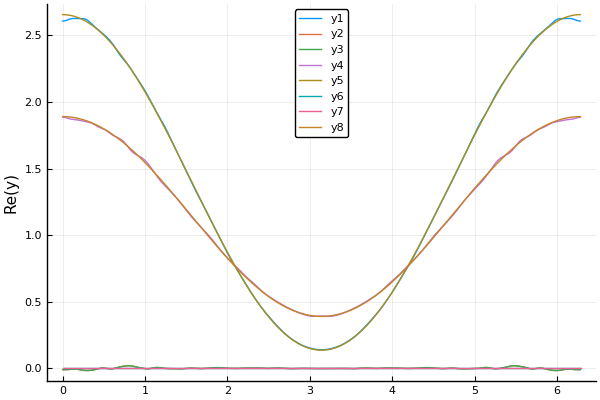

In [28]:
L = 60
S_X_num = z_spect(X,L; win = "Par")

S_X_num_plot = complex(zeros(2,2,Nex))
for n = 1 : Nex
    S_X_num_plot[:,:,n] = S_X_num(Z[n])
end

S_X_ana_plot = complex(zeros(2,2,Nex))
for n = 1 : Nex
    S_X_ana_plot[:,:,n] = S_X_ana(Z[n])
end

plot(Theta, [S_X_num_plot[1,1,:] S_X_num_plot[2,1,:] S_X_num_plot[1,2,:] S_X_num_plot[2,2,
            :] S_X_ana_plot[1,1,:] S_X_ana_plot[2,1,:] S_X_ana_plot[1,2,:] S_X_ana_plot[2,2,:]])

## Estimating the spectral factor using CKMS

In [29]:
L = 60
lags = 0:L

LL = Int(floor(L/2))
lam1 = 1 .- 6*((0:LL)/L).^2 .+ 6*((0:LL)/L).^3
lam2 = 2*(1 .- (LL+1:L)/L).^3
lam = [lam1; lam2]

P = Autocov(X,lags);

In [30]:
l = Matrix_CKMS_c(P);

S_X_minus_num(z) = sum([l[i+1]*z^(-i) for i = 0 : length(l)-1])

S_X_minus_num (generic function with 1 method)

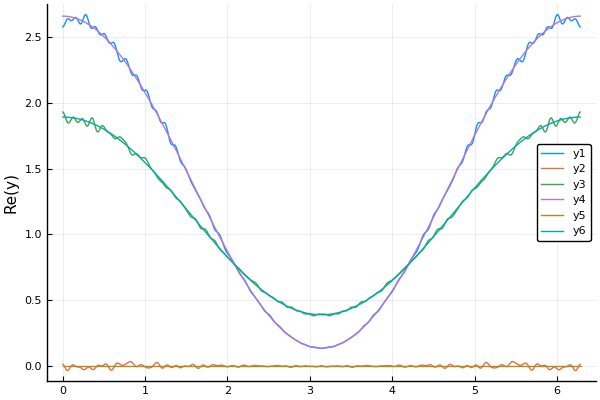

In [31]:
S_X_num_sf(z) = S_X_minus_num(z)*S_X_minus_num(z)'

S_X_num_sf_plot = complex(zeros(2,2,Nex))
for n = 1 : Nex
    S_X_num_sf_plot[:,:,n] = S_X_num_sf(Z[n])
end

plot(Theta, [S_X_num_sf_plot[1,1,:] S_X_num_sf_plot[1,2,:] S_X_num_sf_plot[2,2,
            :] S_X_ana_plot[1,1,:] S_X_ana_plot[1,2,:] S_X_ana_plot[2,2,:]])

## Test a simple process